# Clustering: Elbow Curve, Visualization, Sub-segment Modeling Baseline Performance

In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline as pipe_imb
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn import compose
from sklearn import neighbors
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [ ]:
f = open('OM_D3_Dataset_2_nx-features', 'rb')
data_nx = pickle.load(f)
f.close()
print(data_nx.shape)

In [3]:
X= data_nx.drop(["CustomerID","label"],axis=1)
y= data_nx["label"]

In [4]:
cat_vars= ['isContactable','City', 'last_coupon_type_used','Device']
X.drop(cat_vars,axis=1,inplace=True)
num_vars=list(X.columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipe_num = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ct = ColumnTransformer([
    #("categorical_vars", pipe_cat, cat_vars),
    ("numeric_vars", pipe_num, num_vars),
    
], remainder="passthrough")

In [7]:
# Create a data frame to store the results
def print_results(headline, true_value, pred, probs):
    scores=[]
    CM = confusion_matrix(true_value, pred)
    scores.append(headline)
    scores.append(accuracy_score(true_value, pred))      #accuracy
    scores.append(int(CM[1,1]))                          #TP
    scores.append(int(CM[0,1]))                          #FP
    scores.append(int(CM[0][0]))                         #TN
    scores.append(int(CM[1][0]))                         #FN
    scores.append(precision_score(true_value, pred))     #precision
    scores.append(recall_score(true_value, pred))        #recall
    scores.append(roc_auc_score(true_value, probs))      #roc_auc
    p, r, _ = precision_recall_curve(true_value, probs) 
    scores.append(auc(r,p))                              #pr_auc
    scores.append(f1_score(true_value, pred, average="macro"))            #f1-score
    return scores

score_names = ['method','accuracy','TP','FP','TN','FN','precision','recall','roc_auc','pr_auc','f1']
dfAcc = pd.DataFrame(data=np.zeros(shape=(0,11)), columns = score_names)

# K-means integration

## Drawing inertia curves (i.e. elbow) for different combination of k value and PCA components

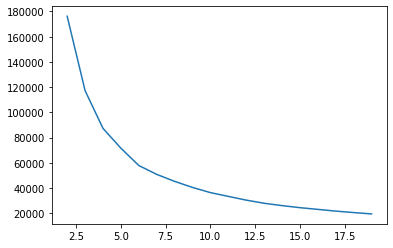

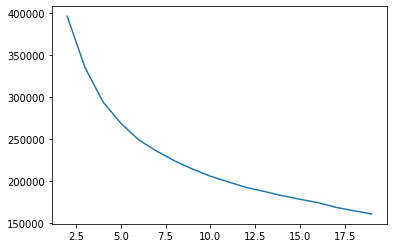

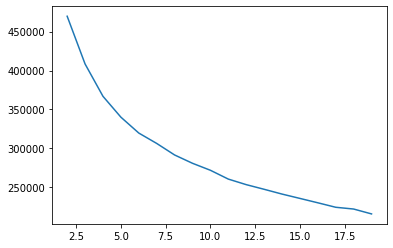

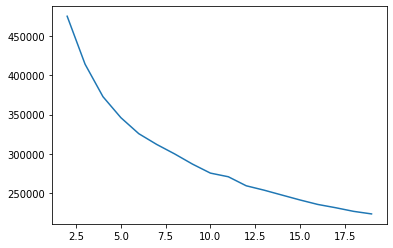

In [8]:
for c in [2, 10, 20, 30]:
    x_values = []
    y_values = []
    for k in range(2, 20):
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=c)),
            ("clustering", KMeans(n_clusters=k))
        ])
        pipe.fit(X)
        x_values.append(k)
        y_values.append(pipe.named_steps["clustering"].inertia_)

    plt.plot(x_values, y_values)
    plt.show()

## Explained Variance Ratio Curve (as a function of PCA n_components)

Text(0.5, 0, 'n_components')

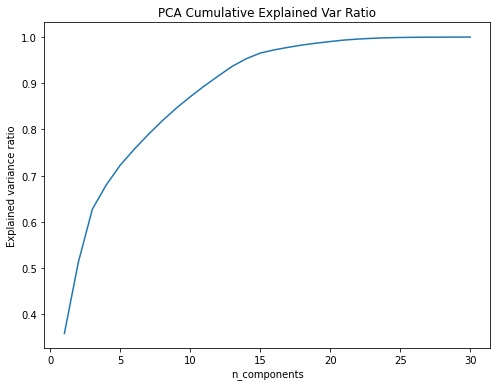

In [9]:
#Explained_variance_ratio_ vs. n_comp

n_val=[]
exp_val=[]
for i in range(len(pipe.named_steps["pca"].explained_variance_ratio_)):
    n_val.append(i+1)
    exp_val.append(np.sum(pipe.named_steps["pca"].explained_variance_ratio_[:i+1]))
    
plt.figure(figsize=(8,6))
plt.plot(n_val,exp_val)
plt.title("PCA Cumulative Explained Var Ratio")
plt.ylabel("Explained variance ratio")
plt.xlabel("n_components")


In [17]:
# explained_variance_ratio_ = X.XX

np.sum(pipe.named_steps["pca"].explained_variance_ratio_[:10])


0.8708754634466255

## 3D depiction of clusters for k=4

In [23]:
import plotly.express as px

plt.figure(figsize=(24,16))

    
# visualization
pipe_vis = Pipeline([ ('imputer'      , SimpleImputer(strategy='median')),
                      ('scaler'       , StandardScaler()),
                      ('pca'          , PCA(n_components=10)),
                      ('tsne'         , TSNE(n_components=3))
                     ])

tsne_dim = pipe_vis.fit_transform(X)


# clustering
pipe_clustering = Pipeline([  ('imputer'      , SimpleImputer(strategy='median')),
                              ('scaler'       , StandardScaler()),
                              ('dim_red'      , PCA(n_components=10)),
                              ('clustering'   , KMeans(n_clusters=4)),
                            ])

pipe_clustering.fit(X)

km_label = pipe_clustering.named_steps["clustering"].labels_

# draw datapoints

fig = px.scatter_3d(x=tsne_dim[:, 0], y=tsne_dim[:, 1], z=tsne_dim[:, 2],color=km_label)

#  plt.title("3D Visualization of Scaled Train Data\nTSNE n_comp = 3  ,  " + "k-means clusters = " + str(k)) 

fig.show();


<Figure size 1728x1152 with 0 Axes>

# Create "cluster" feature for dataset using k-means. k=4 selected

In [ ]:
# clustering
pipe_clustering = Pipeline([  ('imputer'      , SimpleImputer(strategy='median')),
                              ('scaler'       , StandardScaler()),
                              ('dim_red'      , PCA(n_components=10)),
                              ('clustering'   , KMeans(n_clusters=4)),
                            ])

pipe_clustering.fit(X)

km4_label = pipe_clustering.named_steps["clustering"].labels_

X4 = X.copy()
X4["cluster"] = km4_label

X4.head(2)

In [ ]:
# print cluster types 

print(X4["cluster"].unique())

# create subsets of main data by cluster-based filtering

X4_0 = X4[X4["cluster"]==0]
X4_1 = X4[X4["cluster"]==1]
X4_2 = X4[X4["cluster"]==2]
X4_3 = X4[X4["cluster"]==3]

y4_0 = y.filter(X4_0.index)
y4_1 = y.filter(X4_1.index)
y4_2 = y.filter(X4_2.index)
y4_3 = y.filter(X4_3.index)


# Summarize clusters

clu_df= pd.DataFrame({"y_label": y, "cluster": X4["cluster"]})
clu_pvt = pd.crosstab(clu_df["cluster"],clu_df["y_label"])
clu_pvt["cluster_churn_rate"] = clu_pvt[1.0]/(clu_pvt[0.0]+clu_pvt[1.0])
clu_pvt["cluster_weight_in_total"] = (clu_pvt[0.0]+clu_pvt[1.0])/(np.sum(clu_pvt[1.0])+np.sum(clu_pvt[0.0]))

def percentage_format(x):
    return f'{x:.2%}'

clu_pvt = clu_pvt.style.format({'cluster_churn_rate': percentage_format,
                                'cluster_weight_in_total': percentage_format})
clu_pvt


## Prediction by using cluster-based data subsets

In [21]:
list_of_X_subsets = [X4_0, X4_1, X4_2, X4_3]

# Drop cluster label from subsets

for elem in list_of_X_subsets:
    elem.drop(["cluster"],inplace=True,axis=1)
    
# Test train split for each subset

X4_0_train, X4_0_test, y4_0_train, y4_0_test = train_test_split(X4_0, y4_0, test_size=0.33, random_state=42)
X4_1_train, X4_1_test, y4_1_train, y4_1_test = train_test_split(X4_1, y4_1, test_size=0.33, random_state=42)
X4_2_train, X4_2_test, y4_2_train, y4_2_test = train_test_split(X4_2, y4_2, test_size=0.33, random_state=42)
X4_3_train, X4_3_test, y4_3_train, y4_3_test = train_test_split(X4_3, y4_3, test_size=0.33, random_state=42)


# for sake of efficiency, create a matrix

cluster_train_test_matrix = [[X4_0_train, X4_0_test, y4_0_train, y4_0_test],
                                [X4_1_train, X4_1_test, y4_1_train, y4_1_test],
                                [X4_2_train, X4_2_test, y4_2_train, y4_2_test],
                                [X4_3_train, X4_3_test, y4_3_train, y4_3_test]]

In [24]:
# Create a function that fits an LoR model and returns predictions

def func_run_lr_D3(X_trn, X_tst, y_trn, y_tst, name, dfAcc):
    
    ovsmp_pipe = pipe_imb([('ct'        , ct),
                           ('sampler'   , RandomOverSampler(random_state=42,
                                                           sampling_strategy = 0.6)),
                           ('classifier', LogisticRegression(random_state=42, max_iter=100000))
                              ]
                       )

    params = [{'classifier__C'      : [0.1,0.3,0.5,0.7,1], 
               'classifier__penalty': ['l1'],
               'classifier__solver' : ['liblinear', 'saga'],
               'sampler__sampling_strategy'  : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
              }
              ,

              {
              'classifier__C'      : [0.1,0.3,0.5,0.7,1], 
               'classifier__penalty': ['l2'], 
               'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
               'sampler__sampling_strategy'  : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
              }
             ]

    # train/validation with the same ratio of classes
    kfold = StratifiedKFold(n_splits = 4, random_state = 42, shuffle=True) 

    grid = GridSearchCV(ovsmp_pipe, 
                        param_grid = params, 
                        cv = kfold, 
                        scoring = 'f1_macro', 
                        verbose = 1,
                        n_jobs = -1)

    # Run the grid search 
    grid.fit(X_trn, y_trn)
    print(grid.best_estimator_,'\n')
    print('Best parameters  :', grid.best_params_)
    print('\nTraining F1_macro:', grid.score(X_trn, y_trn))
    print('Test F1_macro :', grid.score(X_tst, y_tst))

    # print results

    pred_probs = grid.predict_proba(X_tst)[:,1]

    scores = print_results(name, y_tst, grid.predict(X_tst), pred_probs)

    dftmp = pd.DataFrame([scores], columns=score_names)

    dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
    dfAcc[['TP','FP', 'TN', 'FN']] = dfAcc[['TP','FP', 'TN', 'FN']].astype(int)
    
    return dfAcc

In [25]:
# Create a function that fits an XGB model and returns predictions

def func_run_xgb_D3(X_trn, X_tst, y_trn, y_tst, name, dfAcc):
    ovsmp_pipe = pipe_imb([      ('imputer'   , SimpleImputer(strategy="median")),
                                   ('scaler'    , StandardScaler()),
                                   ('sampler'   , RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.8)),
                                   ('classifier', XGBClassifier(objective='binary:logistic', 
                                                                eval_metric = f1_macro,
                                                                n_estimators=1000, 
                                                                eta=0.001, # default 0.3
                                                                max_depth=3, 
                                                                subsample=0.6, 
                                                                min_child_weight=50, 
                                                                gamma=3, 
                                                                reg_lambda=3, 
                                                                alpha=3, 
                                                                colsample_bytree=0.5, 
                                                                #colsample_bylevel=0.5,
                                                               # scale_pos_weight = 0.35
                                                               )
                                                   )
                            ]
                   )

    params = [{
                  }
                 ]

    # train/validation with the same ratio of classes
    kfold = StratifiedKFold(n_splits = 4, random_state = 42, shuffle=True) 

    grid = GridSearchCV(ovsmp_pipe, 
                        param_grid = params, 
                        cv = kfold, 
                        scoring = 'f1_macro', 
                        verbose = 1,
                        n_jobs = -1)

    # Run the grid search 
    grid.fit(X_trn, y_trn)
    print(grid.best_estimator_,'\n')
    print('Best parameters  :', grid.best_params_)
    print('\nTraining F1_macro:', grid.score(X_trn, y_trn))
    print('Test F1_macro :', grid.score(X_tst, y_tst))

    # print results

    pred_probs = grid.predict_proba(X_tst)[:,1]

    scores = print_results(name, y_tst, grid.predict(X_tst), pred_probs)

    dftmp = pd.DataFrame([scores], columns=score_names)

    dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
    dfAcc[['TP','FP', 'TN', 'FN']] = dfAcc[['TP','FP', 'TN', 'FN']].astype(int)
    
    return dfAcc

In [ ]:
# get baselines for each subset // LoR

for c, elem in pd.DataFrame(cluster_train_test_matrix).iterrows():
    dfAcc = func_run_lr_D3(cluster_train_test_matrix[c][0], 
                     cluster_train_test_matrix[c][1],  
                     cluster_train_test_matrix[c][2],  
                     cluster_train_test_matrix[c][3],  
                     "D5_LoR_km-clu-oversmp-" + str(c), 
                     dfAcc)

In [ ]:
LoR_clu_base_perf = dfAcc
LoR_clu_base_perf 

In [ ]:
# get baselines for each subset // XGB

for c, elem in pd.DataFrame(cluster_train_test_matrix).iterrows():
    dfAcc = func_run_xgb_D3(cluster_train_test_matrix[c][0], 
                             cluster_train_test_matrix[c][1],  
                             cluster_train_test_matrix[c][2],  
                             cluster_train_test_matrix[c][3],  
                             "D5_XGB_km-clu-oversmp-" + str(c), 
                             dfAcc)
    

In [ ]:
dfAcc

# Export table & data subsets

In [30]:
dfAcc_pck = dfAcc.copy()
import pickle 
fx = open("D5_results_table-1_kmeans", 'wb') 
pickle.dump(dfAcc_pck, fx)
fx.close()

In [31]:
cluster_data = [X4_0, X4_1, X4_2, X4_3, y4_0, y4_1, y4_2, y4_3]
clu_datalist = cluster_data.copy()
import pickle 
fx = open("D5_datasets_kmeans", 'wb') 
pickle.dump(clu_datalist, fx)
fx.close()

# PERMUTATION IMPORTANCE

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(grid, X_train, y_train,
                               n_repeats=30,
                             random_state=42)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(r.importances);